## PDS Price Predictor

Why is a Yellow Taxi Cab from the Empire State Building to Times Square $20? In this project, we will explore the justifications behind the pricing of Yellow Taxi Cabs in New York City.
By understanding the relevant features associated with rides, we can develop models that estimate how much different taxi rides will cost. Finally, using our model, we will compare the prices an Uber and a Yellow Taxi Cab would charge for the same trip in New York City. Our ultimate goal is to answer the question "Do Uber and Yellow Taxi set prices according to a similar model?". In addition, we aim to provide users with recommendations on which taxi service, Uber or Yellow Taxi, to take for a given trip in NYC. 

<img src="https://github.com/ComputAni/PDS-Price-Predictor/raw/master/UberVsTaxi.jpg">

### Table of Contents

- [Introduction](#Introduction)
- [Getting the Data](#Getting-the-Data)
- [Feature Engineering](#Feature-Engineering)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Linear Model Take 1](#Linear-Model-Take-1)
- [Linear Model Take 2](#Linear-Model-Take-2)
- [Gradient Boosting Model](#Gradient-Boosting-Model)
- [PCA](#PCA)
- [Compare and Contrast with Uber](#Compare-and-Contrast-with-Uber)
- [Resources and References](#Resources-and-References)

First, install the geopy, sodapy, and uber_rides modules via `pip`:
    
    $ pip install geopy
    
    $ pip install sodapy
    
    $ pip install uber_rides
    
Next, make sure the following imports work for you:

In [1]:
# Basic Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, requests, re
from bs4 import BeautifulSoup
from unicodedata import normalize
%matplotlib inline
# Data
from sodapy import Socrata
# Machine Learning Modules
import scipy.stats as stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
# Geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
# Datetime, Holiday imports
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
# Uber API related includes
from uber_rides.session import Session
from uber_rides.client import UberRidesClient
import time

## Introduction

In order to understand the pricing model of Uber and other taxi companies, we need to identify patterns in trips that have already been made. Unfortunately, Uber does not make past trips (in general, not for one specific user) publicly available, so we focused on data from an equally popular transportation service: Yellow Taxi. In particular, we focused on the greater New York area, as a plethora of historical trip data was available (described below). 

Furthermore, we needed a metric to quantify the performance of this relevant data. Specifically, we found the Uber API to give us real-time pricing information about trips. We collected this data through the API, and made relevant comparisons between Uber's and our Model's pricing.

Our pipeline is as follows:

1) Get original Yellow Taxi data: Use Socrata API to scrape dataset from Yellow Taxi Trip Data. Collect the most recent trip information available (Jan - June 2016, roughly 1 million entries).

2) Clean data: Clean up the entries in this dataset. Discard any invalid entries.

3) Feature engineering: Using just the starting location, ending location, trip dropoff, and trip pickup times, come up with a set of features that can potentially influence transportation pricing schemes. Perform analysis on the data to learn more about the features. 

4) Model creation: Split original dataset into train + test sets. Use cross-validation and mean squared error to assess performance of different models (i.e linear regression). Pick best performing model.

5) Comparison: Using Uber API, make sample requests to get pricing information of trips. Generate features for these trips and get a Model pricing estimate as well. Compare them using MSE.

Ultimately, you can see that a good performing model (one metric being a lower MSE) can indicate that the features we chose are appropriate in describing a similarity between Yellow Cab and Uber pricing models. While we are aware that Uber has many "hidden" features that may contribute to their pricing (this is a good assumption, or else what exactly differentiates Uber!), we hope to uncover some of the more significant features that may contribute to fare price.

## Getting the Data

We use a dataset sampled from NYC Open Data's 2016 Yellow Taxi Trip Data, which includes yellow taxi trip records in NYC from January to June 2016. Fields include pick-up and drop-off dates/times, pick-up and drop-off locations (latitude and longitude), and much more. For more information, check out: https://data.cityofnewyork.us/Transportation/2016-Yellow-Taxi-Trip-Data/k67s-dv2t. 

We use the NYC Open Data API: https://dev.socrata.com/foundry/data.cityofnewyork.us/uacg-pexx to request a sample dataset of 1000000 Yellow Taxi Cab trip records. First, we create a Socrata client object below, passing `None` for the second argument since we only need to create an unauthenticated client for access to the public data. 

In [2]:
client = Socrata("data.cityofnewyork.us", None)

In [5]:
# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
max_size = 50000
total_size = 1000000
num_chunks = total_size // max_size #Should be 200
total_data = []
results = []
print("Requesting: %d chunks" % num_chunks);
for i in range(num_chunks):
    curr_offset = max_size*i
    results = client.get("uacg-pexx", limit=50000, offset=curr_offset)
    total_data += results

Requesting: 20 chunks


In [6]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(total_data)
print("Before scrubbing data size: ", len(results_df))
results_df = results_df[results_df.pickup_latitude != '0']
results_df = results_df[results_df.pickup_longitude != '0']
results_df = results_df[results_df.dropoff_latitude != '0']
results_df = results_df[results_df.dropoff_longitude != '0']
print("After scrubbing data size: ", len(results_df))

#Write the scraped data to our cab_data.csv file
#results_df.to_csv('cab_data.csv')

Before scrubbing data size:  1000000
After scrubbing data size:  991795


Great! Now that we have our scraped dataset, we'll move on to feature engineering.

## Feature Engineering

First, load the scraped dataset. 

In [7]:
cab_data = pd.read_csv("cab_data.csv")

Next, we remove extraneous features in the dataset.

In [8]:
# Removes uneccesary columns, as we will be creating our own features.
def scrub_df(df):
    del df['fare_amount']
    del df['improvement_surcharge']
    del df['mta_tax']
    del df['passenger_count']
    del df['payment_type']
    del df['ratecodeid']
    del df['store_and_fwd_flag']
    del df['tip_amount']
    del df['tolls_amount']
    del df['trip_distance']
    del df['vendorid']
    return df

basic_df = scrub_df(cab_data)

Next, the distance of each trip is an important feature that affects price. Calculate the geographical distance between two lat/lon pairs.

In [10]:
#Init the geolocator for calculating distances
geolocator = Nominatim()

#Pairs the lat/lon columns into one column (for walkscore/geolocator)
def get_latlng(df):
    def f(x,y):
        coord = "%f, %f" % (x, y)
        return coord
    
    df['start_latlng'] = df[['dropoff_latitude', 'dropoff_longitude']].apply(lambda x: f(*x), axis=1)
    df['end_latlng'] = df[['pickup_latitude', 'pickup_longitude']].apply(lambda x: f(*x), axis=1)
    
    return df

#Given input dataframe, computes distance of trip using geolocator and start/end lat/lon positions
def get_dist(df):

    def get_d(x,y):
        return geodesic(x, y).miles

    df['distance'] = df[['start_latlng', 'end_latlng']].apply(lambda x: get_d(*x), axis=1)
    
    return df

In [11]:
df_with_latlng = get_latlng(basic_df)
df_with_dist = get_dist(df_with_latlng)

Furthermore, we found that particular date trends, such as day of week, time of day, holidays, etc. could potentially affect demand for taxis, and therefore, price. 
Specifically, we decomposed each cab query into years, months, days, hours, minutes, seconds, day of week, and whether or not it is a holiday.

In [16]:
def create_date_features(df, start_date, end_date):
    dt_format = '%Y-%m-%dT%H:%M:%S.%f'
    # Get the list of US federal hollidays
    cal = USFederalHolidayCalendar()
    us_holidays = cal.holidays(start=start_date, end=end_date).to_pydatetime()
    
    date_feature_names = ["tpep_dropoff_datetime", "tpep_pickup_datetime"]
    date_feature_to_datetimes = {"tpep_dropoff_datetime" : [],
                                 "tpep_pickup_datetime" : []}
    for feature_name in date_feature_names:
        y, mo, d = [], [], [] # Year, Month, Day
        h, mi, s = [], [], [] # Hours, Minutes, Seconds
        day_of_week = [] # Day of the Week
        is_holiday = [] # Is the date a holiday?
        for time in df[feature_name]:
            # Extract the datetime object from the timestamp
            dt = datetime.strptime(time, dt_format)
            date_feature_to_datetimes[feature_name].append(dt)
            # Add the Year/Month/Day
            y.append(dt.year)
            mo.append(dt.month)
            d.append(dt.day)
            # Add Hour/Minute/Second
            h.append(dt.hour)
            mi.append(dt.minute)
            s.append(dt.second)
            # Add Day of the Week
            day_of_week.append(dt.weekday())
            # Add is_holiday
            y_m_d = datetime(dt.year, dt.month, dt.day)
            is_holiday.append(1 if y_m_d in us_holidays else 0)
        df[feature_name + "_years"] = y
        df[feature_name + "_months"] = mo
        df[feature_name + "_days"] = d
        df[feature_name + "_hours"] = h
        df[feature_name + "_minutes"] = mi
        df[feature_name + "_seconds"] = s
        df[feature_name + "_day_of_week"] = day_of_week
        df[feature_name + "_is_holiday"] = is_holiday
    durations = []
    for dropoff_time, pickup_time in zip(date_feature_to_datetimes["tpep_dropoff_datetime"],
                                         date_feature_to_datetimes["tpep_pickup_datetime"]):
        duration = (dropoff_time - pickup_time).total_seconds() / 60.0
        durations.append(round(duration))
    
    df["duration"] = durations
    return df

In [17]:
#Generate the new dataframe with date features
start = '2016-01-01'
end = '2016-12-31'
df_with_date = create_date_features(df_with_dist, start, end)

#Write to temporary CSV file for holding
df_with_date.to_csv("date_data.csv")

Lastly, we found that weather patterns have an effect on usage of transportation. Consider rain: users are less likely to walk/bike longer distances if it's raining, thereby increasing demand for taxi services. Other important features included snow level, precipitation, temperature, humidity, visibility, and dew point.

In [18]:
# Get weather data for 2016 and returns dictionary of date features
# Scrapes wunderground.com weather information for greater NY area.
def init_weather_features(start_date, end_date):
    date = start_date
    date_to_features = dict()
    # weather related features to extract
    feature_names = ["Mean Temperature",
                    "Max Temperature",
                    "Min Temperature",
                    "Dew Point",
                    "Average Humidity",
                    "Precipitation",
                    "Snow",
                    "Wind Speed",
                    "Visibility"]
    while (date <= end_date):
        # station: KNYC (Central Park, New York)
        (year, month, day) = (date.year, date.month, date.day)
        #print(year, month, day)

        # Get the HTML of the weather webpage
        url_format_string = "http://www.wunderground.com/history/airport/KNYC/{year}/{month}/{day}/DailyHistory.html"
        url = url_format_string.format(year=year, month=month, day=day)
        response = requests.get(url)

        if response.status_code != 200:
            print("An error occurred while getting NYC weather data for {day}-{month}-{year}".format(
            year=year, month=month, day=day))
        else:
            features = dict()
            html = response.content
            soup = BeautifulSoup(html, "lxml")
            table = soup.find_all(attrs={'id': 'historyTable'})[0]

            table_rows = table.find_all('tr')
            feature_list = []
            found_features = [False, False, False, False, False, False, False, False, False]
            # Loop through the entries of the table to find weather features
            for tr in table_rows:
                td = tr.find_all('td')
                # normalize the text to account for string encoding
                row = [normalize('NFKD', i.text) for i in td]

                # There are multiple rows named 'snow' and 'precipitation'
                # Use len(row) > 2 to get the "right" rows
                if len(row) > 2 and row[0] in feature_names:
                    data = row[1].strip() # remove extraneous whitespace
                    result = re.sub('[^0-9.]','', data) # remove all alphabetic characters
                    if result == "": # if there's no feature value (e.g.: T, for traces of precipitation/snow)
                        result = 0
                    features[row[0]] = result
                    found_features[feature_names.index(row[0])] = True
                    feature_list.append(result)

            # If a feature is not present in the table, set it to a default value: 0
            for found_feature, feature_name in zip(found_features, feature_names):
                if (not found_feature):
                    features[feature_name] = 0
            assert(len(features) == len(feature_names))
            date_to_features[date] = features
        date = date + timedelta(1)
        
    return date_to_features

# insert method for dictionary (list of values for each key)
def dict_insert(d, key, val):
    if key in d:
        d[key].append(val)
    else:
        d[key] = [val]

# put the weather-related features into the dataframe
def create_weather_features(df, date_to_features):
    
    dt_format = '%Y-%m-%dT%H:%M:%S.%f'
    weather_features = dict()
    for time in df["tpep_dropoff_datetime"]:
        # Extract the datetime object from the timestamp
        dt = datetime.strptime(time, dt_format)
        y_m_d = datetime(dt.year, dt.month, dt.day)
        weather_dict = date_to_features[y_m_d]
        for feature_name in weather_dict:
            dict_insert(weather_features, feature_name, weather_dict[feature_name])
        
    for feature_name in weather_features:
        df[feature_name] = weather_features[feature_name]
    return df

In [19]:
#Initialize the weather scraping function over the year of 2016
start_date = datetime(2016, 1, 1)
end_date = datetime(2016, 12, 31)
date_features = init_weather_features(start_date, end_date)

#Open our previously curated date related features and append our new weather features.
open_date_df = pd.read_csv("date_data.csv")
df_with_weather = create_weather_features(open_date_df, date_features)

Great! We now have a dataframe with a core set of features. Let's save it to a file! The next step is to take a closer look at our input data through an exploratory data analysis.

In [ ]:
df_with_weather.head()
#df_with_weather.to_csv('data_with_features.csv')

## Exploratory Data Analysis

First, we load the dataset we saved to a file in the previous section using pandas.

In [5]:
cab_data = pd.read_csv("data_with_features.csv")
del cab_data["Unnamed: 0"] # Delete extraneous columns
del cab_data["Unnamed: 0.1"]
del cab_data["Unnamed: 0.1.1"]
cab_data.head()

,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,end_latlng,distance,...,duration,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility
0,40.777241,-73.951744,40.776424,-73.952850,15.35,2016-04-03T00:09:40.000,2016-04-02T23:55:45.000,"40.777241, -73.951744","40.776424, -73.952850",0.080895,...,14,42,50,34,16,51,0.09,0.0,13,10
1,40.777611,-73.951080,40.789371,-73.943352,12.30,2016-04-22T09:45:11.000,2016-04-22T09:27:51.000,"40.777611, -73.951080","40.789371, -73.943352",0.907077,...,17,71,79,62,53,55,0.00,0.0,4,10
2,40.770386,-73.966476,40.761303,-73.973183,5.80,2016-04-29T20:26:47.000,2016-04-29T20:23:57.000,"40.770386, -73.966476","40.761303, -73.973183",0.718773,...,3,52,58,45,34,48,0.05,0.0,6,10
3,40.767288,-73.966675,40.764381,-73.995583,10.80,2016-04-08T11:21:10.000,2016-04-08T11:10:26.000,"40.767288, -73.966675","40.764381, -73.995583",1.529830,...,11,45,50,40,26,48,0.01,0.0,7,10
4,40.744068,-73.988991,40.754742,-73.979820,7.30,2016-04-28T09:09:32.000,2016-04-28T09:04:28.000,"40.744068, -73.988991","40.754742, -73.979820",0.879828,...,5,54,59,48,30,51,0.00,0.0,5,10


Inspecting the data, we notice that there are some trips with prices less than 0! We remove rows with negative prices below.

In [6]:
price_filter = cab_data["total_amount"] > 0
cab_data = cab_data[price_filter]

While conducting EDA, we can examine continuous features using histograms. For example, here's a histogram showing the distribution of the `total_amount` variable.

Text(0,0.5,'Frequency')

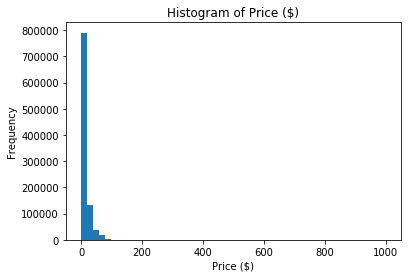

In [7]:
plt.hist(cab_data["total_amount"], bins=50)
plt.title("Histogram of Price ($)")
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

The histogram of the price feature is quite skewed: most trips have relatively low prices, but there's a long-tail of very expensive trips. Below, we generate a probability plot of our sample data against the quantiles of a normal distribution.

((array([-4.82353497, -4.64362929, -4.54636112, ...,  4.54636112,
          4.64362929,  4.82353497]),
  array([ -1.18124694,  -1.15966257,  -1.15966257, ...,  49.26588698,
          52.80125761,  73.12033514])),
 (0.80562893254150381, -1.0662559962684076e-11, 0.80562467708200025))

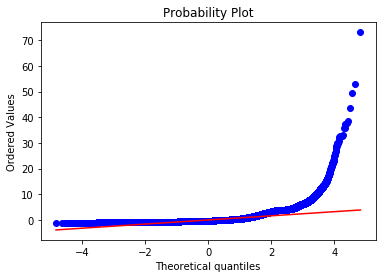

In [8]:
# First, standardize the total_amount data by subtracting by the mean and dividing by the standard deviation
std_total_amount = (cab_data["total_amount"] - np.mean(cab_data["total_amount"]))/np.std(cab_data["total_amount"])
stats.probplot(std_total_amount, dist="norm", plot=plt)

The fact that our data doesn't follow the red line (quantiles of the normal distribution) suggests that the distribution of price is quite non-normal. This implies that a linear model will be a poor fit, since a linear model attempts to fit a Gaussian to the price. We try a log transform of the price feature below.

Text(0,0.5,'Frequency')

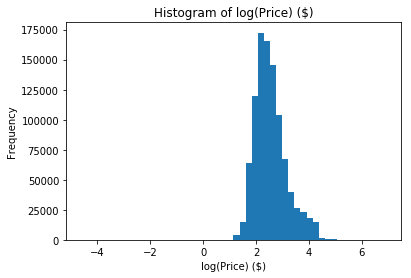

In [9]:
cab_data["log_total_amount"] = np.log(cab_data["total_amount"] + 1)
plt.hist(np.log(cab_data["total_amount"]), bins=50)
plt.title("Histogram of log(Price) ($)")
plt.xlabel('log(Price) ($)')
plt.ylabel('Frequency')

The plot above looks more normal, as evidenced by the qq plot below.

((array([-4.82353497, -4.64362929, -4.54636112, ...,  4.54636112,
          4.64362929,  4.82353497]),
  array([ 0.00995033,  0.26236426,  0.26236426, ...,  6.52032653,
          6.58796315,  6.90705503])),
 (0.53922967709457903, 2.6428798090460202, 0.97236933129256198))

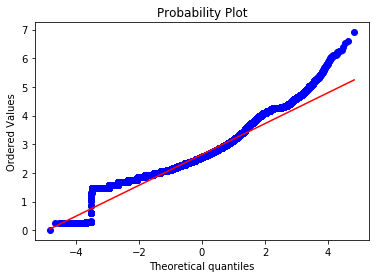

In [10]:
std_log_total_amount = (cab_data["log_total_amount"] - np.mean(cab_data["log_total_amount"]))/np.std(cab_data["log_total_amount"])
stats.probplot(cab_data["log_total_amount"], dist="norm", plot=plt)

Next, let's create a scatter plot of the price vs. the distance (miles) of the trip.

Text(0,0.5,'Price ($)')

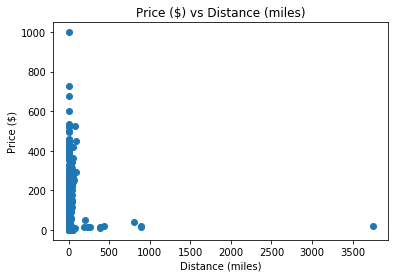

In [11]:
plt.scatter(cab_data["distance"], cab_data["total_amount"])
plt.title("Price ($) vs Distance (miles)")
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')

The majority of trips are clustered around distances between 0-500 miles, but there are a few trips with very large distances, one greater than 3500 miles! The scope of our model is NYC, so later (see section: [Linear Model Take 2](#Linear-Model-Take-2)), we'll filter out trips longer than a threshold of 50 miles.

Due to the large number of data points squashed in a small region, we cannot glean useful information about any trends between price and distance from the above plot. Instead, let's create a plot of price vs. distance for the first 1000 trips below.

Text(0,0.5,'Price ($)')

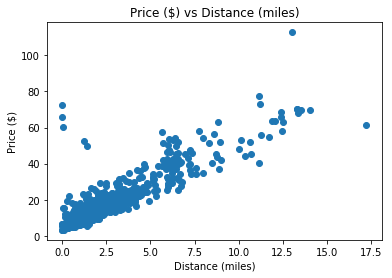

In [12]:
num_points = 1000
plt.scatter(cab_data["distance"][:num_points], cab_data["total_amount"][:num_points])
plt.title("Price ($) vs Distance (miles)")
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')

From the above plot, we can observe a linear trend between the price of a trip and its distance (miles). One other approach we can try in the case of a large number of data points is to create a 2D histogram (heat map) of the data.

Text(0,0.5,'Price ($)')

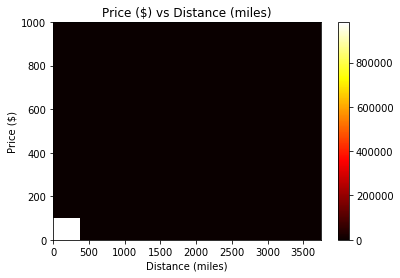

In [30]:
plt.hist2d(cab_data["distance"],cab_data["total_amount"],bins=10);
plt.colorbar();
plt.set_cmap('hot')
plt.title("Price ($) vs Distance (miles)")
plt.xlabel('Distance (miles)')
plt.ylabel('Price ($)')

The heatmap also supports our conclusion: the vast majority of trips have prices <\$100 and distances <500 miles. How many trips have prices >\$100? 

In [31]:
high_prices = cab_data.loc[cab_data['total_amount'] >= 100]
print("%d trips cost more than $100" % len(high_prices))
print("The most expensive trip costs $%0.3f" % max(cab_data['total_amount']))
high_prices.head()

1348 trips cost more than $100
The most expensive trip costs $998.300


,dropoff_latitude,dropoff_longitude,pickup_latitude,pickup_longitude,total_amount,tpep_dropoff_datetime,tpep_pickup_datetime,start_latlng,end_latlng,distance,...,Mean Temperature,Max Temperature,Min Temperature,Dew Point,Average Humidity,Precipitation,Snow,Wind Speed,Visibility,log_total_amount
541,40.687695,-74.181274,40.785633,-73.969040,112.80,2016-04-18T08:38:22.000,2016-04-18T07:57:53.000,"40.687695, -74.181274","40.785633, -73.969040",13.029107,...,67,82,51,30,34,0.00,0.0,4,10,4.734443
1053,40.217884,-74.004501,40.724216,-74.006996,209.15,2016-04-07T02:29:58.000,2016-04-07T01:13:02.000,"40.217884, -74.004501","40.724216, -74.006996",34.936829,...,53,58,48,45,69,0.09,0.0,7,9,5.347822
2507,40.722610,-74.063568,40.770317,-73.867020,115.30,2016-04-08T10:54:51.000,2016-04-08T09:50:31.000,"40.722610, -74.063568","40.770317, -73.867020",10.827208,...,45,50,40,26,48,0.01,0.0,7,10,4.756173
2520,40.697224,-73.811440,40.781620,-73.979401,103.59,2016-04-03T01:07:46.000,2016-04-03T00:04:33.000,"40.697224, -73.811440","40.781620, -73.979401",10.565227,...,42,50,34,16,51,0.09,0.0,13,10,4.650048
2533,40.687714,-74.182350,40.644825,-73.781975,138.88,2016-04-02T19:40:58.000,2016-04-02T18:49:45.000,"40.687714, -74.182350","40.644825, -73.781975",21.243622,...,55,61,49,42,63,0.15,0.0,5,10,4.940785


We'll remember this point about the distribution of prices, when attempting to improve our initial model (see [Linear Model Take 2](#Linear-Model-Take-2)).

## Linear Model Take 1

Having analyzed our data in the previous section, let's build a simple linear model to predict the price of a trip. Our first step is to define the subset of features from the original dataset that we wish to use in creating a price model.

In [13]:
feature_names = ['distance', 'duration', 'tpep_dropoff_datetime_years', 'tpep_dropoff_datetime_months',
       'tpep_dropoff_datetime_days', 'tpep_dropoff_datetime_hours',
       'tpep_dropoff_datetime_minutes', 'tpep_dropoff_datetime_seconds',
       'tpep_dropoff_datetime_day_of_week',
       'tpep_dropoff_datetime_is_holiday', 'tpep_pickup_datetime_years',
       'tpep_pickup_datetime_months', 'tpep_pickup_datetime_days',
       'tpep_pickup_datetime_hours', 'tpep_pickup_datetime_minutes',
       'tpep_pickup_datetime_seconds', 'tpep_pickup_datetime_day_of_week',
       'tpep_pickup_datetime_is_holiday', 'Mean Temperature',
       'Max Temperature', 'Min Temperature', 'Dew Point',
       'Average Humidity', 'Precipitation', 'Snow', 'Wind Speed',
       'Visibility']

Next, we create a numpy array holding the examples from our dataset. For each example, we extract the features defined above. We also create a list of the `log(price)` for each example.

In [14]:
def create_features(df, feature_names):
    features = []
    for feature_name in feature_names:
        features.append(df[feature_name])
    
    X = np.array(features).T
    y = df["log_total_amount"].values
    return (X,y)

(X,y) = create_features(cab_data, feature_names)

Next, we partition the data into training and testing splits, and further partition the training data into training and cross-validation splits.

In [15]:
def create_train_test_split(X,y):
    X_, X_test, y_, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
    X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size = 0.3, random_state=0)
    
    return (X_train, y_train, X_cv, y_cv, X_test, y_test)

(X_train, y_train, X_cv, y_cv, X_test, y_test) = create_train_test_split(X,y)

Finally, we build a simple linear model on the training data and evaluate its performance by computing the mean squared error on the validation data. 

In [16]:
def train_linear_regression(X_train, y_train, X_test, y_test):
    model = linear_model.LinearRegression(fit_intercept=True, normalize=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    print("Mean squared error: %.5f" % error)
    return (model, y_pred, error)

(model, y_pred, error) = train_linear_regression(X_train, y_train, X_cv, y_cv)

Mean squared error: 0.10979


We define a utility function that takes in a data frame of test examples and a model, and returns a list of the model's predictions on the test examples, as well as the list of actual prices.

In [17]:
def predict(df, model):
    (X,y) = create_features(df)
    y_pred = model.predict(X)
    y_actual = df["log_total_amount"].values
    return y_pred, y_actual

## Linear Model Take 2

In the previous section, we developed a simple linear model that achieved a mean squared error of 0.10979 on the validation set. Can we do better? In [Exploratory Data Analysis](#Exploratory-Data-Analysis), we noticed that we had several outliers with really high distances and/or high prices. Also, we noticed that some trips' pickup/dropoff location lat-lon coordinates were not even in NYC! Below, we filter the dataset according to these criteria.

In [37]:
def filter_data(cab_data):
    # Price range of trip: $[0,50]
    cab_data = cab_data[cab_data["total_amount"] >= 0]
    cab_data = cab_data[cab_data["total_amount"] <= 50]
    
    # Distance range of trip: [0,100] miles
    cab_data = cab_data[cab_data["distance"] >= 0]
    cab_data = cab_data[cab_data["distance"] <= 100]
    
    # Lat-Lon coordinates of NYC:
    # Latitude: [40.4,41]
    # Longitude: [-74.3, -73.5]
    cab_data = cab_data[cab_data['dropoff_latitude'] >= 40.4]
    cab_data = cab_data[cab_data['dropoff_latitude'] <= 41]
    cab_data = cab_data[cab_data['dropoff_longitude'] >= -74.3]
    cab_data = cab_data[cab_data['dropoff_longitude'] <= -73.5]
    
    cab_data = cab_data[cab_data['pickup_latitude'] >= 40.4]
    cab_data = cab_data[cab_data['pickup_latitude'] <= 41]
    cab_data = cab_data[cab_data['pickup_longitude'] >= -75]
    cab_data = cab_data[cab_data['pickup_longitude'] <= -72]
    
    return cab_data
cab_data = filter_data(cab_data)

Let's run our linear model on the filtered dataset. 

In [38]:
(X,y) = create_features(cab_data, feature_names)
(X_train, y_train, X_cv, y_cv, X_test, y_test) = create_train_test_split(X,y)
(model, y_pred, error) = train_linear_regression(X_train, y_train, X_cv, y_cv)

Mean squared error: 0.06454


Great, we've improved our model's mean squared error on the validation data from 0.110 to 0.065! Let's take a look at our model's coefficients to interpret how our model is arriving at its estimated prices.

In [39]:
coeffs = model.coef_
for coeff,feature_name in zip(model.coef_, feature_names):
    print("Slope on feature %s is: %0.8f" % (feature_name, coeff))

Slope on feature distance is: 0.24414178
Slope on feature duration is: 0.00031976
Slope on feature tpep_dropoff_datetime_years is: -0.00000000
Slope on feature tpep_dropoff_datetime_months is: 1.92983951
Slope on feature tpep_dropoff_datetime_days is: 0.06453345
Slope on feature tpep_dropoff_datetime_hours is: 0.00690622
Slope on feature tpep_dropoff_datetime_minutes is: 0.00000669
Slope on feature tpep_dropoff_datetime_seconds is: 0.00000648
Slope on feature tpep_dropoff_datetime_day_of_week is: 0.01752429
Slope on feature tpep_dropoff_datetime_is_holiday is: 0.15100658
Slope on feature tpep_pickup_datetime_years is: 0.00000000
Slope on feature tpep_pickup_datetime_months is: -1.92201693
Slope on feature tpep_pickup_datetime_days is: -0.06305235
Slope on feature tpep_pickup_datetime_hours is: -0.00343917
Slope on feature tpep_pickup_datetime_minutes is: -0.00013180
Slope on feature tpep_pickup_datetime_seconds is: -0.00001118
Slope on feature tpep_pickup_datetime_day_of_week is: -0.02

One of the advantages of a simple linear model is its interpretability: A coefficient of 0.244 on distance suggests that an increase of one mile to the trip causes the price of the trip goes up by \$0.244 (holding all other variables constant). We can interpret features with really low weights, such as `tpep_pickup_datetime_years`, as having little influence on the predicted price. This makes sense, since the years feature is actually constant for all trips! Another interesting observation is the coefficient of 0.151 on is_holiday. This means that, all things equal, the price of a trip is $0.15 more on holidays!

## Gradient Boosting Model

Next, we try a more complicated model: `GradientBoostingRegressor`, which uses an ensemble of different regressors to boost performance (check out: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html). First, let's train the model.

In [18]:
clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

Let's inspect the model's mean-squared errors on the training and validation sets. We also provide a baseline MSE achieved by predicting the mean price of the training data for all examples.

In [41]:
print("Training MSE: ", np.mean((clf.predict(X_train) - y_train)**2))
print("Baseline training MSE: ", np.mean((np.mean(y_train) - y_train)**2))

Training MSE:  0.0155140948981
Baseline training MSE:  0.223299264109


In [42]:
print("CV MSE: ", np.mean((clf.predict(X_cv) - y_cv)**2))
print("Baseline CV MSE: ", np.mean((np.mean(y_train) - y_cv)**2))

CV MSE:  0.0156928642345
Baseline CV MSE:  0.222950525042


Our model seems to be learning - we're achieving significant improvement in MSE vs. the baseline.

Below is a graph showing the training and testing MSE as a function of sample size. Notice that, interestingly, we get close to MSE of 0.02 on the validation set even after fitting a model on just the first 1000 samples!

Text(0,0.5,'MSE')

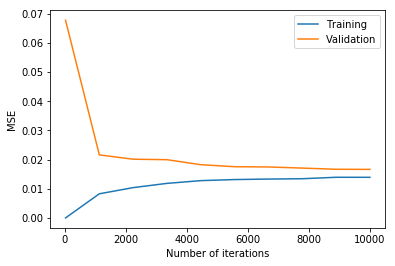

In [45]:
def get_err_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    return np.array([np.mean((clf.predict(X[:n_samples]) - y[:n_samples])**2), 
                     np.mean((clf.predict(X_cv) - y_cv)**2)])

n_samples = [int(x) for x in np.linspace(20, 10000, 10)] # 1000, 2000, ..., 10000
errors = np.array([get_err_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, errors[:,0], n_samples, errors[:,1])
plt.legend(["Training", "Validation"])
plt.legend(["Training", "Validation"])
plt.xlabel("Number of iterations")
plt.ylabel("MSE")

## Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a common way to speed up machine learning algorithms. PCA's [wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis) describes that PCA tends to convert possibly correlated variables into a set of linearly uncorrelated variables. PCA is used to reduce data of high dimensionality to fewer dimensions, making it easier to analyze and train models.

We use Scikit-learn's PCA class, that takes in the number of components and allows us to transform our data to the resulting number of dimensions. More information at: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

Below, we will run PCA with Linear Regression. We run it for a range of dimensions [1,27] (we have 27 dims in the original dataset) to determine the optimal number of dimensions for PCA. 

In [77]:
def applyPCAWithLR(X_train, y_train, X_test, y_test):
    numCols = X_train.shape[1]
    errors = []
    print(numCols)
    for i in range(numCols):
        print(i+1)
        # Initialize the PCA class and pass in the number of dimensions to which you want to reduce your data to.
        pca = PCA(n_components = i+1)

        # Fit the training data to the PCA model.
        pca.fit(X_train)

        # Reduce the dimensionality of the training set.
        newX_train = pca.transform(X_train)

        # Reduce the dimensionality of the testing set.
        newX_test = pca.transform(X_test)
        
        (model, y_pred, error) = train_linear_regression(newX_train, y_train, newX_test, y_test)
        errors.append(error)
    return errors

cvError = applyPCAWithLR(X_train, y_train, X_cv, y_cv)

27
1
Mean squared error: 0.21881
2
Mean squared error: 0.21856
3
Mean squared error: 0.21856
4
Mean squared error: 0.21855
5
Mean squared error: 0.21856
6
Mean squared error: 0.21855
7
Mean squared error: 0.21835
8
Mean squared error: 0.21834
9
Mean squared error: 0.21826
10
Mean squared error: 0.21826
11
Mean squared error: 0.21825
12
Mean squared error: 0.21825
13
Mean squared error: 0.21826
14
Mean squared error: 0.12460
15
Mean squared error: 0.08745
16
Mean squared error: 0.06481
17
Mean squared error: 0.06470
18
Mean squared error: 0.06468
19
Mean squared error: 0.06468
20
Mean squared error: 0.06458
21
Mean squared error: 0.06458
22
Mean squared error: 0.06455
23
Mean squared error: 0.06454
24
Mean squared error: 0.06454
25
Mean squared error: 0.06454
26
Mean squared error: 0.06454
27
Mean squared error: 0.06454


Now, we have a list of error values for each number of reduced dimensions. We plot a graph of the error vs number of dimensions.

Text(0,0.5,'MSE')

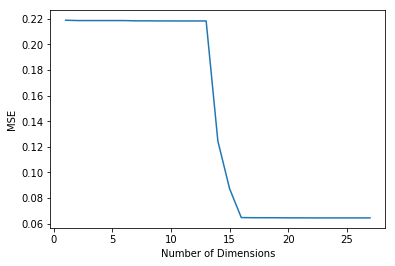

In [71]:
xAxisPlot = list(range(1, X_train.shape[1]+1))
plt.plot(xAxisPlot, cvError)
plt.xlabel('Number of Dimensions')
plt.ylabel('MSE')

We can see that the error rate becomes mostly constant after 16 dimensions. Hence, for our data, 16 dimensions is optimal. 

Next, we run PCA with Gradient Boosting using 16 dimensions, in an attempt to obtain even better results.

In [70]:
def applyPCA(X_train, X_test, numComponents):
    pca = PCA(n_components = numComponents)

    # Fit the training data to the PCA model.
    pca.fit(X_train)

    # Reduce the dimensionality of the training set.
    newX_train = pca.transform(X_train)

    # Reduce the dimensionality of the testing set.
    newX_test = pca.transform(X_test)
    
    return newX_train, newX_test

pcaX_train, pcaX_cv = applyPCA(X_train, X_cv, 16)
clfPCA = GradientBoostingRegressor()
clfPCA.fit(pcaX_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [66]:
print("Training MSE: ", np.mean((clfPCA.predict(pcaX_train) - y_train)**2))
print("Baseline training MSE: ", np.mean((np.mean(y_train) - y_train)**2))

Training MSE:  0.0166747462133
Baseline training MSE:  0.223299264109


In [67]:
print("CV MSE: ", np.mean((clfPCA.predict(pcaX_cv) - y_cv)**2))
print("Baseline CV MSE: ", np.mean((np.mean(y_train) - y_cv)**2))

CV MSE:  0.0168506091987
Baseline CV MSE:  0.222950525042


In [44]:
def get_err_samples(clf, X, y, X_cv, y_cv, n_samples):
    clf.fit(X[:n_samples], y[:n_samples])
    return np.array([np.mean((clf.predict(X[:n_samples]) - y[:n_samples])**2), 
                     np.mean((clf.predict(X_cv) - y_cv)**2)])

n_samples = [int(x) for x in np.linspace(20, 10000, 10)] # 1000, 2000, ..., 10000
errors = np.array([get_err_samples(clfPCA, pcaX_train, y_train, pcaX_cv, y_cv, n) for n in n_samples])
plt.plot(n_samples, errors[:,0], n_samples, errors[:,1])
plt.legend(["Training", "Validation"])
plt.xlabel("Number of iterations")
plt.ylabel("MSE")

NameError: name 'clfPCA' is not defined

Based on the cross-validation errors of each model, it seems that Gradient Boosting (without PCA) seems to be performing the best. We'll use this as our final model (note: it's also appropriate to use the model with PCA, since it's a much simpler model that performs nearly as well!) 

Finally, let's look at this model's performance on the test set - a proxy for how our model will do on future trip data!

In [78]:
print("Test MSE: ", np.mean((clf.predict(X_test) - y_test)**2))
print("Baseline Test MSE: ", np.mean((np.mean(y_train) - y_test)**2))

Test MSE:  0.0167250077094
Baseline Test MSE:  0.22328588427


## Compare and Contrast with Uber

The outline for the comparison between Yellow Taxi and Uber is as follows:

1) Specify an interval of time and a sampling rate for which we'll make real-time queries to Uber for cab pricing.

2) Randomly select a subset of trips from the original dataset. We'll use the starting and ending position of each trip only, and build the remaining features based off of current information (e.g web scraping to obtain current weather, current datetime, etc...).

3) For each randomly selected trip, make a real-time Uber request to get the price of the Uber trip. Generate weather and datetime features for that trip based on current information.

4) Input the generated features for current trip into our Model and get the predicted Yellow Taxi price.

5) Compare model-predicted pricings to Uber-pricings.

First, specify the time period (in minutes). Let's sample for 1 hour at a rate of 1 query per 5 minutes. This means we will make 60/5 = 12 queries to Uber API per hour (12 sample trips).

In [25]:
#Step 1: Determine interval for sampling Uber API
time_period = 1*60 #In X hrs * 60 minutes 
sample_rate = 5 #In 1 sample per *sample_rate* minutes
num_samples = time_period // sample_rate
print("We will be making %d calls to uber API." % num_samples)

#Step 2: Get random subset of data to use as test points
cab_data = pd.read_csv("data_with_features.csv")
del cab_data["Unnamed: 0"]
del cab_data["Unnamed: 0.1"]
del cab_data["Unnamed: 0.1.1"]

#Filter out any nonzero price values
price_filter = cab_data["total_amount"] > 0
cab_data = cab_data[price_filter]

#Filter out any negative distance values
dist_filter = cab_data['distance'] > 0
cab_data = cab_data[dist_filter]

#Add the log total amount (for price verification)
cab_data["log_total_amount"] = np.log(cab_data["total_amount"] + 1)

#Randomly sample data
sample_data = cab_data.sample(n=num_samples)
sample_data = sample_data[['start_latlng', 'end_latlng', 'distance', 'duration']]
#print(sample_data)

We will be making 12 calls to uber API.


In [26]:
#List of features we are using in our model
feature_names = ['distance', 'duration', 'tpep_dropoff_datetime_years', 'tpep_dropoff_datetime_months',
       'tpep_dropoff_datetime_days', 'tpep_dropoff_datetime_hours',
       'tpep_dropoff_datetime_minutes', 'tpep_dropoff_datetime_seconds',
       'tpep_dropoff_datetime_day_of_week',
       'tpep_dropoff_datetime_is_holiday', 'tpep_pickup_datetime_years',
       'tpep_pickup_datetime_months', 'tpep_pickup_datetime_days',
       'tpep_pickup_datetime_hours', 'tpep_pickup_datetime_minutes',
       'tpep_pickup_datetime_seconds', 'tpep_pickup_datetime_day_of_week',
       'tpep_pickup_datetime_is_holiday', 'Mean Temperature',
       'Max Temperature', 'Min Temperature', 'Dew Point',
       'Average Humidity', 'Precipitation', 'Snow', 'Wind Speed',
       'Visibility']
print("Number of features: ", len(feature_names))

Number of features:  27


Now that we have our randomly sampled 12 trips, we can generate features for each trip and compute Uber estimates.

getPriceNow() is our interface for Uber API, and we can make a request for an Uber and get pricing information. The server_token is purposefully redacted.

In [38]:
# Gets the current price given the start and end locations.
def getPriceNow(startLat, startLong, endLat, endLong):
    # Left out the server token as the repo is public.
    session = Session(server_token="")
    client = UberRidesClient(session)

    response = client.get_price_estimates(
        start_latitude=startLat,
        start_longitude=startLong,
        end_latitude=endLat,
        end_longitude=endLong,
        seat_count=1
    )

    estimate = response.json.get('prices')

    return estimate

In [20]:
#Given a dataframe of trips, computes features for Model estimates and Uber estimates for pricing of each trip.
#Returns model features for each trip and uber prices
#Writes to "price_estimates.csv" (contains Uber prices for the trips) 
#Writes to "price_features.csv" (contains weather/datetime features for the trips -> 
#"price_features.csv" will be used to estimate Yellow Taxi prices for the same trips using our model)
def generate_estimates(sample_data):


    data_with_features = []
    uber_estimates = []

    for (idx,row) in sample_data.iterrows():

        ########## CREATE TIME/DATE/WEATHER FEATURES FOR MODEL ESTIMATE ###############
        F = open('price_estimates.csv', 'a')
        
        #Pickup time is now, dropoff is trip duration after pickup
        pickup_time = datetime.now()
        dropoff_time = pickup_time + timedelta(minutes=row['duration'])

        #Format start and end times for feature extraction
        start = datetime(pickup_time.year, pickup_time.month, pickup_time.day)
        start = '%4d-%02d-%02d' % (start.year, start.month, start.day)
        end = datetime(pickup_time.year, pickup_time.month, pickup_time.day + 1)
        end = '%4d-%02d-%02d' % (end.year, end.month, end.day)

        start_date = datetime(pickup_time.year, pickup_time.month, pickup_time.day)
        end_date = datetime(pickup_time.year, pickup_time.month, pickup_time.day)

        weather_date_features = init_weather_features(start_date, end_date)

        #Format pickup/dropoff time
        pickup_time = '%4d-%02d-%02dT%02d:%02d:%f' % (pickup_time.year, pickup_time.month, pickup_time.day, pickup_time.hour, pickup_time.minute, pickup_time.second)
        dropoff_time = '%4d-%02d-%02dT%02d:%02d:%f' % (dropoff_time.year, dropoff_time.month, dropoff_time.day, dropoff_time.hour, dropoff_time.minute, dropoff_time.second)
        curr_row = dict()
        curr_row["tpep_dropoff_datetime"] = str(dropoff_time)[:len(dropoff_time)-3] #strftime('%Y-%m-%dT%H:%M:%S.%f', dropoff_time)
        curr_row["tpep_pickup_datetime"] = str(pickup_time)[:len(pickup_time)-3] #strftime('%Y-%m-%dT%H:%M:%S.%f', pickup_time)

        curr_row['distance'] = row['distance']
        
        #Convert to dataframe and get date  + weather features
        curr_row = pd.DataFrame([curr_row])
        curr_row = create_date_features(curr_row, start, end)
        curr_row = create_weather_features(curr_row, weather_date_features)

        #Write the synthesized row of features to csv file (append)
        curr_row.to_csv("price_features.csv", mode='a',header=False)
        data_with_features.append(curr_row)

        ######### GET UBER ESTIMATE ##############
        start_coord = row['start_latlng'].split(',')
        end_coord = row['end_latlng'].split(',')
        curr_uber_estimates = getPriceNow(float(start_coord[0]), float(start_coord[1]), float(end_coord[0]), float(end_coord[1]))
        uberX_estimate = curr_uber_estimates[1]

        high_estimate = uberX_estimate['high_estimate']
        low_estimate = uberX_estimate['low_estimate']
        avg_estimate = (high_estimate + low_estimate) / 2

        all_estimates = (high_estimate, low_estimate, avg_estimate)
        
        uber_estimates.append(all_estimates)

        print("uberX estimate: %s" % (avg_estimate))
        F.write(str(all_estimates) + "\n")
        
        ####### COMPARE UBER ESTIMATE WITH MODEL ESTIMATE #########
        F.close()
        
        #Sleep for sample_rate minutes
        time.sleep(sample_rate * 60)
    

    
    return (data_with_features, uber_estimates)

In [ ]:
#Generate estimates for our sampled_data
features, estimates = generate_estimates(sample_data)

uberX estimate: 10.5


Great! We now have our Uber estimates for each randomly selected trip (located in price_estimates.csv) as well as the generated features for each trip (price_features.csv). We can now parse both and input the features into our model to get price estimates. We will then compare the model pricing with Uber pricing.

In [19]:
X_test = pd.read_csv('price_features.csv')
del X_test['i']
del X_test['tpep_dropoff_datetime']
del X_test['tpep_pickup_datetime']
model_results = clf.predict(X_test)

In [20]:
uber_pricing_estimates = []
with open('price_estimates.csv', 'r') as f:
    r = csv.reader(f)
    uber_pricing_estimates = list(r)

uber_pricing_estimates.pop(0)

['min_estimate', ' max_estimate', ' avg_estimate']

In [21]:
assert(len(model_results) == len(uber_pricing_estimates))

uber_prices = []
model_prices = []

for i in range(len(model_results)):
    uber_hi, uber_lo, uber_avg = uber_pricing_estimates[i]
    #Weird formatting stuff, ignore for now
    uber_avg = uber_avg[:len(uber_avg)-1]
    uber_hi = uber_hi[1:]

    our_estimate = model_results[i]
    
    if float(uber_avg) < 30: 
        uber_prices.append(float(uber_avg))
        model_prices.append(our_estimate)
        
    print("For trip %d, Model: %f Uber: %s" % (i, np.exp(our_estimate) - 1, uber_avg))


For trip 0, Model: 15.924906 Uber:  15.0
For trip 1, Model: 19.599918 Uber:  20.5
For trip 2, Model: 46.865146 Uber:  62.0
For trip 3, Model: 12.059499 Uber:  13.0
For trip 4, Model: 14.113362 Uber:  12.5
For trip 5, Model: 12.869284 Uber:  9.5
For trip 6, Model: 11.215933 Uber:  9.5
For trip 7, Model: 15.142332 Uber:  17.0
For trip 8, Model: 14.851497 Uber:  15.0
For trip 9, Model: 35.575963 Uber:  54.0
For trip 10, Model: 9.171624 Uber:  9.5
For trip 11, Model: 9.695373 Uber:  9.5
For trip 12, Model: 13.072664 Uber:  11.5
For trip 13, Model: 9.173783 Uber:  9.5
For trip 14, Model: 40.780461 Uber:  55.0
For trip 15, Model: 7.493088 Uber:  12.0
For trip 16, Model: 14.113362 Uber:  14.0
For trip 17, Model: 13.241154 Uber:  10.5
For trip 18, Model: 8.813132 Uber:  9.5
For trip 19, Model: 9.029664 Uber:  9.5
For trip 20, Model: 20.634387 Uber:  18.0
For trip 21, Model: 17.901936 Uber:  16.0
For trip 22, Model: 27.789582 Uber:  26.0
For trip 23, Model: 8.211375 Uber:  9.5
For trip 24, Mode

In [24]:
mse = np.mean((np.exp(model_prices) - 1) - uber_prices)**2
rmse = np.sqrt(mse)
print("The Root Mean Squared Error between Uber's prices and Yellow Taxi Cab prices is: %0.3f" % rmse)

The Root Mean Squared Error between Uber's prices and Yellow Taxi Cab prices is: 1.125


As you can see, the mean squared error (MSE) between the model prices and the uber prices is roughly 1.125. This result is actually quite good because it illustrates only a $1.12 discrepency between the two pricing schemes. We didn't expect the performance to be identical, however, because we are using yellow cab data, and there most definitely are hidden factors that contribute to Uber's pricing model. 

If you look more closely at the pricing differences for each trip, you'll notice that our model struggles with higher-priced Ubers; specifically, our model tends to lowball pricing for high-priced Ubers. Upon closer inspection, we found some of the higher-priced trips to actually be relatively short in trip distance, indicating that Uber's surge pricing algorithm might have been used. We'll discuss this in future scope, but surge pricing could explain the discrepency between model pricing and Uber pricing. With this in mind, we aimed to provide a model that fit smaller, more consistent trips, so in our original dataset, we only trained on trips less than a threshold Yellow-cab fare price. 

Ultimately, there are hidden features and factors that Uber uses in determining its pricing algorithm. We found our model to perform quite well (relative to Uber's ground truth). Most of the discrepancies in pricing can be attributed to hidden features + Uber surge pricing, which probably use a plethora of features not publicly known.

## Future Scope

We can expand upon our work to improve the results and our findings in the following ways:

**1) Use Supply and Demand to determine price**: Uber is known to factor this into their calculation of surge pricing. We couldn't really take this into account due to the lack of data regarding the number of requests from/to a certain location and number of cars available on road. More information about how surge pricing works can be found here: https://www.uber.com/drive/partner-app/how-surge-works/

**2) Use more features like WalkScore, TransitScore**: It would be great to add features that explain the livability of an area - i.e. how good is the public transit in an area, is it walkable? This would help us find the real need of Uber in certain areas and how that correlates with prices. We actually had this feature working, however, we couldn't get it to work on a million data points as we had to convert lat/long coordinates to addresses. However, geopy - the conversion API only allowed 2500 data points for 24 hours. More info about the API can be found on: https://www.walkscore.com/professional/api.php

**3) Model using Neural Nets**: We could use more models to train our data like Neural Networks, in an attempt to reduce our test set error. Since, we have a million data points, we actually have enough data to train a neural network! More information to train a neural network using scikit-learn can be found at: http://scikit-learn.org/stable/modules/neural_networks_supervised.html. We can also use Tensorflow for this purpose: https://www.tensorflow.org/tutorials/ 

**4) Extending scope to different regions, prices and time**:

## Resources and References

https://arxiv.org/pdf/1508.07292.pdf

